In [2]:
# import sys
import numpy as np
import pathlib
import sys

import petsc4py
petsc4py.init(sys.argv)
import dolfin as dl
import hippylib as hl

dl.parameters["form_compiler"]["optimize"]     = True
dl.parameters["form_compiler"]["cpp_optimize"] = True
dl.parameters["form_compiler"]["representation"] = "uflacs"
dl.parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.unicode_minus'] = False

mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}", r"\usepackage{amssymb}"]

In [3]:
# dl.PETScOptions.set("ksp_type", "gmres")
# # PETScOptions.set("ksp_rtol", 1e-12)
# # PETScOptions.set("pc_type", "ilu")
# #PETScOptions.set("snes_type", "ngmres")
# #PETScOptions.set("snes_rtol", 1e-8)
# dl.PETScOptions.set("pc_type", "bjacobi")
# dl.PETScOptions.set("sub_pc_type", "ilu")
# dl.PETScOptions.set("sub_pc_factor_levels", 10)
# #PETScOptions.set("pc_factor_mat_solver_type", "mumps")
# #PETScOptions.set("snes_atol", 1e-8)
# # PETScOptions.set("sub_pc_factor_shift_type", PETSc.POSITIVE_DEFINITE)
# # PETScOptions.set("ksp_error_if_not_converged")
# # dl.PETScOptions.set("error_on_nonconvergence", False)
dl.PETScOptions.set("ksp_monitor", False)

# Quasistatic problem

In [4]:
from PDE_model_help import GenericReprBase, FwdModelSource, FwdBoundary
from PDE_model_help import Misfit, FullTracer, plot_prior
from PDE_model import PDEModel

STATE = 0
PARAMETER = 1

In [6]:
run_dir = 'test/'
theta0 = [0.25]
use_approx = True
which_est = 0
noise_variance = np.power(0.01, 2)

num_samples = 5000
pcn_s = 0.2
p_mode = np.array([0.5, 10.])
p_sigma = np.array([0.4, 0.4])

out_path = run_dir

mcmc_path = run_dir # results in chain_<id> folder

/home/prashant/anaconda3/envs/confen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/prashant/anaconda3/envs/confen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/prashant/anaconda3/envs/confen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

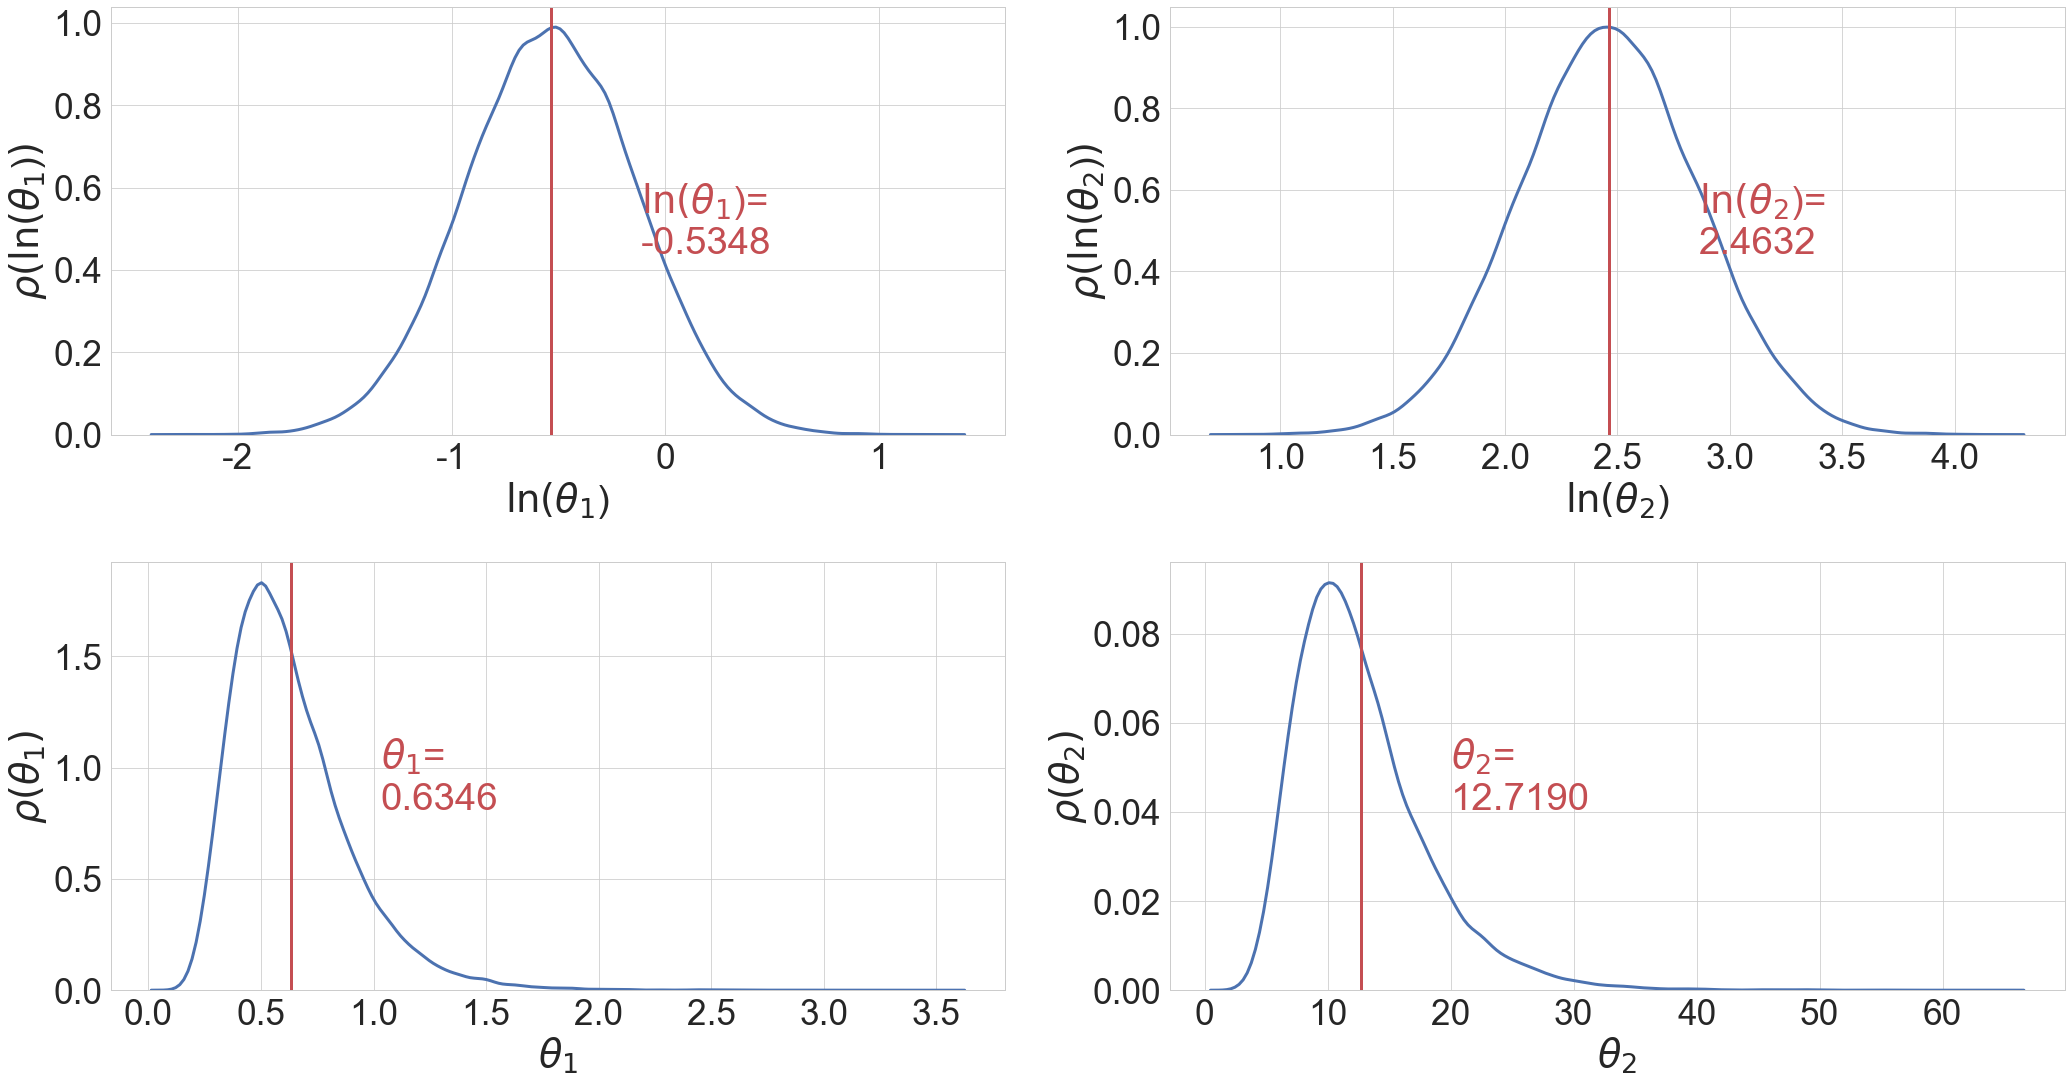

In [7]:
# mcmc chain
chain_id = 1

# set paths
out_path_chain = out_path + 'chain_%d/' % (chain_id)
pathlib.Path(out_path_chain).mkdir(parents=True, exist_ok=True)
mcmc_path_chain = mcmc_path + 'chain_%d/' % (chain_id)
pathlib.Path(mcmc_path_chain).mkdir(parents=True, exist_ok=True)

# load mesh
mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), 50, 50)

# FE space
FE_polynomial = 1
Vu = dl.FunctionSpace(mesh, "Lagrange", FE_polynomial)

# Define elements: P1 and real number
P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 2)
R   = dl.FiniteElement("R", mesh.ufl_cell(), 0)

# parameter space
# k, alpha
param_dim = 2
Vh_PARAMETER = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=param_dim)

# Define the state space (solution space) together with parameter space
Vh = [Vu, Vh_PARAMETER, None]

print_freq = 10

# create pde problem
pde = PDEModel(Vh, save = False, out_path = out_path_chain)
pde.print_freq = print_freq

pde.use_approx = use_approx
pde.which_est = which_est

# create misfit function
total_u = np.zeros((1,1))
misfit = Misfit(total_u)
misfit.set_noise_variance([noise_variance], no_scale = True)

# set prior distribution (mode from the validation data in the paper)
p_mean = np.log(p_mode) + p_sigma**2
mean = pde.generate_parameter()
mean.set_local(p_mean)

# prior distribution (lognormal)
prior = hl.GaussianRealPrior(Vh[PARAMETER], np.diag(p_sigma**2), mean=mean)

# plot prior
plot_prior(prior)

# create hippylib model (consisting of forward problem, prior distribution, and misfit function)
# Forward problem: must provide 'solveFwd()' method
# misfit: must provide 'cost()' method
model = hl.Model(pde, prior, misfit)

# preconditioned Crank-Nicolson (pCN) sampler
kernel = hl.pCNKernel(model)
kernel.parameters["s"] = pcn_s
chain = hl.MCMC(kernel)

# save data
np.save(mcmc_path_chain + 'data.npy', misfit.data)

tracer = FullTracer(Vh, mcmc_path_chain, print = True, print_freq = print_freq)

chain.parameters["number_of_samples"]     = num_samples
chain.parameters["burn_in"]               = 0
chain.parameters["print_progress"]        = 10
chain.parameters["print_level"]           = -1

for idx in range(chain_id-1):
    chain.consume_random() # exhaust randoms used in previous chains

noise = dl.Vector()
prior.init_vector(noise,"noise")
hl.parRandom.normal(1., noise)
m0 = dl.Vector()
prior.init_vector(m0, 0)
prior.sample(noise,m0)

# Test model

In [8]:
## solve linear model
print("\n\nGetting low-fidelity solution\n")
#pde.verbosity = 3
pde.solve_fwd_bck_lf()

## compute error using exact solutions
print("\n\nCompute error at one parameter sample\n")
x = [None, pde.generate_parameter(), None]
m_test = dl.Vector()
prior.sample(noise, m_test)
print('test parameter: {}'.format(m_test))
x[PARAMETER].set_local(m_test)

## solve nonlinear model
print("\n\nSolve original forward and dual problem\n")
pde.solve_fwd_bck(x)

## save
pde.set_save_files('exact')
pde.save_state()

## solve approximate error to compute QoI
print("\n\nSolve for approximate errors\n")
pde.solve_err(x)

## save
pde.set_save_files('err')
pde.save_state()

#print
print('\n *** comparing various estimates ***\n')
print('\nQ(u0) = ', pde.lf_qoi)

print('\n\nQoI using exact\n')
print('Q(u) = ', pde.qoi_using_exact)
print('\nError Q(u) - Q(u0) = ', pde.qoi_est_direct_using_exact)
print('\nEstimate 1 Q(u) - Q(u0) = ', pde.qoi_est_using_exact[0])
print('\nEstimate 2 Q(u) - Q(u0) = ', pde.qoi_est_using_exact[1])

print('\n\nQoI using approximate\n')
print('\nQ(u) = ', pde.qoi_using_approx)
print('\nError Q(u) - Q(u0) = ', pde.qoi_est_direct_using_approx)
print('\nEstimate 1 Q(u) - Q(u0) = ', pde.qoi_est_using_approx[0])
print('\nEstimate 2 Q(u) - Q(u0) = ', pde.qoi_est_using_approx[1])



Getting low-fidelity solution

Solve LF problem with parameters [0.25]
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.005e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 3.128e-15 (tol = 1.000e-10) r (rel) = 4.465e-14 (tol = 1.000e-06)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.960e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 1.357e-15 (tol = 1.000e-10) r (rel) = 6.923e-14 (tol = 1.000e-06)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


Compute error at one parameter sample

test parameter: <dolfin.cpp.

# Run mcmc

In [9]:
dl.set_log_active(False)

## run MCMC
print('\n\n *** Running MCMC simulation ***\n\n')
n_accept = chain.run(m0, qoi = None, tracer = tracer)
print("Number accepted = {0}".format(n_accept))
tracer.save()



 *** Running MCMC simulation ***


Solve for errors with parameters [ 0.57380979 23.00660478]
  Count:  0 , QoI:  [-0.27486457]
Acceptance ratio:  0.0 %
Solve for errors with parameters [ 1.02502823 14.53276038]
  Count:  10 , QoI:  [-0.26730578]
Acceptance ratio:  54.54545454545454 %
Solve for errors with parameters [ 0.66013664 12.73241125]
  Count:  20 , QoI:  [-0.25428826]
Acceptance ratio:  52.38095238095239 %
Solve for errors with parameters [0.5482211  9.93807326]
  Count:  30 , QoI:  [-0.23948995]
Acceptance ratio:  48.38709677419355 %
Solve for errors with parameters [0.45976413 9.43080255]
  Count:  40 , QoI:  [-0.23110132]
Acceptance ratio:  48.78048780487805 %
Solve for errors with parameters [0.35426395 7.65221163]
  Count:  50 , QoI:  [-0.20915922]
Acceptance ratio:  45.09803921568628 %
Solve for errors with parameters [0.33349651 7.27562438]
  Count:  60 , QoI:  [-0.20314646]
Acceptance ratio:  40.98360655737705 %
Solve for errors with parameters [0.36792287 6.30609995

Solve for errors with parameters [0.12555035 2.97150577]
  Count:  620 , QoI:  [-0.02853828]
Acceptance ratio:  30.75684380032206 %
Solve for errors with parameters [0.13808268 2.47908229]
  Count:  630 , QoI:  [-0.01850911]
Acceptance ratio:  30.744849445324878 %
Solve for errors with parameters [0.13792261 2.78908232]
  Count:  640 , QoI:  [-0.03361432]
Acceptance ratio:  30.577223088923557 %
Solve for errors with parameters [0.12672934 2.25114608]
  Count:  650 , QoI:  [0.00938308]
Acceptance ratio:  30.721966205837177 %
Solve for errors with parameters [0.12352182 2.50137407]
  Count:  660 , QoI:  [-0.00103974]
Acceptance ratio:  31.01361573373676 %
Solve for errors with parameters [0.12669688 2.44127047]
  Count:  670 , QoI:  [-0.00189134]
Acceptance ratio:  30.849478390462 %
Solve for errors with parameters [0.14469165 2.20879735]
  Count:  680 , QoI:  [-0.01234677]
Acceptance ratio:  30.690161527165934 %
Solve for errors with parameters [0.16009783 2.55448346]
  Count:  690 , Qo

Solve for errors with parameters [0.07339554 3.49059221]
  Count:  1240 , QoI:  [0.01294305]
Acceptance ratio:  28.767123287671232 %
Solve for errors with parameters [0.07570852 4.30726897]
  Count:  1250 , QoI:  [-0.03460117]
Acceptance ratio:  28.85691446842526 %
Solve for errors with parameters [0.10163132 3.36038577]
  Count:  1260 , QoI:  [-0.01950049]
Acceptance ratio:  28.945281522601114 %
Solve for errors with parameters [0.09876127 3.01907688]
  Count:  1270 , QoI:  [0.00332775]
Acceptance ratio:  28.95357985837923 %
Solve for errors with parameters [0.10970894 2.8095009 ]
  Count:  1280 , QoI:  [0.00013005]
Acceptance ratio:  28.96174863387978 %
Solve for errors with parameters [0.11635496 2.89538051]
  Count:  1290 , QoI:  [-0.01355329]
Acceptance ratio:  28.892331525948876 %
Solve for errors with parameters [0.0932898  3.37344751]
  Count:  1300 , QoI:  [-0.00936277]
Acceptance ratio:  28.97770945426595 %
Solve for errors with parameters [0.10905888 3.3041187 ]
  Count:  13

Acceptance ratio:  27.768773635872503 %
Solve for errors with parameters [0.11644361 2.60738358]
  Count:  1860 , QoI:  [0.00257267]
Acceptance ratio:  27.7270284793122 %
Solve for errors with parameters [0.1085786  3.20431276]
  Count:  1870 , QoI:  [-0.02006196]
Acceptance ratio:  27.792624265098876 %
Solve for errors with parameters [0.10130509 3.21640363]
  Count:  1880 , QoI:  [-0.0114335]
Acceptance ratio:  27.698032961190854 %
Solve for errors with parameters [0.1375424  2.35548746]
  Count:  1890 , QoI:  [-0.01129245]
Acceptance ratio:  27.60444209413009 %
Solve for errors with parameters [0.13140253 2.03896569]
  Count:  1900 , QoI:  [0.01578386]
Acceptance ratio:  27.51183587585481 %
Solve for errors with parameters [0.15463173 2.2989408 ]
  Count:  1910 , QoI:  [-0.02862867]
Acceptance ratio:  27.36787022501308 %
Solve for errors with parameters [0.13809183 2.19939829]
  Count:  1920 , QoI:  [-0.00333347]
Acceptance ratio:  27.381572097865696 %
Solve for errors with paramete

  Count:  2470 , QoI:  [-0.01481398]
Acceptance ratio:  26.669364629704575 %
Solve for errors with parameters [0.10204398 2.83589401]
  Count:  2480 , QoI:  [0.00962939]
Acceptance ratio:  26.642482869810557 %
Solve for errors with parameters [0.10820013 2.9921282 ]
  Count:  2490 , QoI:  [-0.0082192]
Acceptance ratio:  26.69610598153352 %
Solve for errors with parameters [0.10632418 2.9167163 ]
  Count:  2500 , QoI:  [-0.00138686]
Acceptance ratio:  26.789284286285486 %
Solve for errors with parameters [0.13285515 3.00821289]
  Count:  2510 , QoI:  [-0.0383042]
Acceptance ratio:  26.802070888092395 %
Solve for errors with parameters [0.14970873 2.03233581]
  Count:  2520 , QoI:  [-0.00907802]
Acceptance ratio:  26.814756049186833 %
Solve for errors with parameters [0.11999387 2.8069175 ]
  Count:  2530 , QoI:  [-0.01343103]
Acceptance ratio:  26.787830896878706 %
Solve for errors with parameters [0.13221533 2.00018621]
  Count:  2540 , QoI:  [0.01704304]
Acceptance ratio:  26.80047225

  Count:  3090 , QoI:  [-0.04422332]
Acceptance ratio:  27.369783241669367 %
Solve for errors with parameters [0.09771791 3.54350699]
  Count:  3100 , QoI:  [-0.02401122]
Acceptance ratio:  27.378265075782004 %
Solve for errors with parameters [0.09308031 3.76924349]
  Count:  3110 , QoI:  [-0.02957851]
Acceptance ratio:  27.38669238187078 %
Solve for errors with parameters [0.11218575 3.05748776]
  Count:  3120 , QoI:  [-0.01690007]
Acceptance ratio:  27.33098365908363 %
Solve for errors with parameters [0.12266639 2.60098569]
  Count:  3130 , QoI:  [-0.00557637]
Acceptance ratio:  27.371446822101564 %
Solve for errors with parameters [0.13794771 2.65951624]
  Count:  3140 , QoI:  [-0.02743338]
Acceptance ratio:  27.28430436166826 %
Solve for errors with parameters [0.14610737 2.53953788]
  Count:  3150 , QoI:  [-0.03076239]
Acceptance ratio:  27.292922881624882 %
Solve for errors with parameters [0.11669271 2.40919235]
  Count:  3160 , QoI:  [0.01436765]
Acceptance ratio:  27.3014868

KeyboardInterrupt: 